<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Intermediate Report</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201506219 - [up201506219@fe.up.pt](mailto:up201506219@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/>

---

# IART

* [GitHub repository](https://github.com/msramalho/iart)
* [UCI source page](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29)
* [README](dataset/README.ipynb) of the dataset
* [Dataset file](dataset/frogs.csv)
* [Automatic Classification of Anuran Sounds Using Convolutional Neural Networks](report_material/papers/Automatic%20Classification%20of%20Anuran%20Sounds%20Using.pdf)
* [Tensorflow tutorial](https://www.tensorflow.org/get_started/premade_estimators)

# Code

## Initialization

In [16]:
import pandas as pd
import tensorflow as tf
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling
import matplotlib.pyplot as plt

In [17]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
CHECKPOINTS_PATH = "models_checkpoints" # folder that holds the Tensorflow checkpoints
N_FEATURES = 22 # the number of features in the dataset
LABEL_INDEX = 24 # the index in the dataset where the label to predict is
BATCH_SIZE = 100 # batch size for the train, evaluation and prediction
TRAIN_PERCENT = 0.8 # this means 80% of examples will be used for training and 20% for testing
NUM_CLASSES = 10 # last layer, num classifications
NUM_ITEMS = 7195 #Num items in dataset

In [18]:
### Iterations
INNER_LAYERS = [
    [10],
    [20, 20],
    [10, 10, 10]
]

TRAIN_FRACTIONS = [
    0.8,
    0.5,
]

NUM_STEPS = [
    100, 
    1000,
]

## Helper Functions

In this section we include functions that are directed at helping the visualisation of the project, the manipulation of data and the creation, training and evaluation of models

### Chart Drawing functions

In [19]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

def drawNN(hidden_layers, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.axis('off')
    draw_neural_net(ax, .1, .9, .1, .9, hidden_layers)
#     fig.savefig('nn.png')
    

In [20]:
def draw_label_distribution(label_column, title_text):
    label_count = pd.Series.value_counts(label_column, normalize=True, sort=False)
    label_count = label_count.sort_index()
    label_count.plot(kind='barh', title=title_text, stacked=True, fontsize=15, figsize=(8,8), color="darkblue" )
    
def draw_species_distribution_chart(df, title_text="Species Dataset Distribution"):
    species_column = df['Species']
    draw_label_distribution(species_column, title_text)

### Dataset Splitting

In [21]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def _convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return unique_labels, [unique_labels.index(l) for l in labels]

In [22]:
def split_data(df, train_fraction):
    # split into 80% train and 20% test, may need crossvalidation in the future
    train=df.sample(frac=train_fraction, random_state=int(time.time()))
    test=df.drop(train.index)

    # split dataframes into X (features) and y (classes) - use species as label
    train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    # Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
    my_feature_columns = [tf.feature_column.numeric_column(key=key) for key in list(train_x)]
    
    # for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
    _, numeric_train_y = _convert_labels_to_number(train_y.iloc[:,0])
    _, numeric_test_y  = _convert_labels_to_number(test_y.iloc[:,0])
    
    return (train_x, numeric_train_y, test_x, numeric_test_y, my_feature_columns)

### Creating Models

In [23]:
def create_DNN(my_feature_columns, inner_layers_architecture, save_folder_path=None, num_classes=NUM_CLASSES):
    # Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
    classifier = tf.estimator.DNNClassifier(
            feature_columns = my_feature_columns,
            hidden_units = inner_layers_architecture, # 1:-1 removes the first and last elements of the architecture
            n_classes = num_classes, # num nodes of final layer
            model_dir = save_folder_path) # value None means it will be saved in temp, 
                                            # no need to generate path for each iteration
    return classifier

### Training Models

In [24]:
SHUFFLE_PARAM = NUM_ITEMS * 10 #df.shape[0] * 10
def _train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(SHUFFLE_PARAM).repeat().batch(BATCH_SIZE)

In [25]:
def train_model(classifier, train_x, numeric_train_y, num_steps=1000):
    # Train the model - 10 steps
    classifier.train(input_fn=lambda:_train_input_fn(train_x, numeric_train_y), steps=num_steps)

### Evaluating Models

In [26]:
def _eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [27]:
def evaluate_model(classifier, test_x, numeric_test_y):
    # Evaluate the model.
    eval_result = classifier.evaluate(input_fn=lambda:_eval_input_fn(dict(test_x), numeric_test_y))
    return eval_result

## Main

### Loading Data

Got 7195 examples from the .csv


,MFCCs_1,MFCCs_2,MFCCs_3,MFCCs_4,MFCCs_5,MFCCs_6,MFCCs_7,MFCCs_8,MFCCs_9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


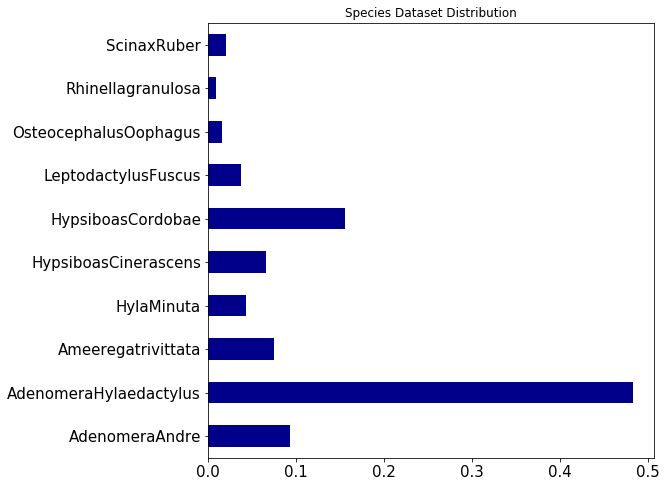

In [36]:
# from csv to pandas Dataframe
df = pd.read_csv(DATASET_PATH)

# draw dataset distribution
draw_species_distribution_chart(df)

df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF
print("Got %d examples from the .csv" % df.shape[0])
df.head()

### Running iterations

In [30]:
# this may take a while
evaluations = []

for train_fraction in TRAIN_FRACTIONS:
    # data splitting
    (train_x, numeric_train_y, test_x, numeric_test_y, my_feature_columns) = split_data(df, train_fraction)
    for inner_architecture in INNER_LAYERS:
        for num_steps in NUM_STEPS:
            #drawNN([N_FEATURES] + inner_architecture + [NUM_CLASSES])
            # DNN model
            classifier = create_DNN(my_feature_columns, inner_architecture)
            train_model(classifier, train_x, numeric_train_y, num_steps)
            eval_result = evaluate_model(classifier, test_x, numeric_test_y)
            # evaluation results
            result_tup = ( (inner_architecture, train_fraction, num_steps), eval_result )
            evaluations.append(result_tup)
    


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmusw7x4o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efbf6839400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpmusw7x4o/model.ckpt.
INFO:tensorflow:loss = 275.37265, step = 1
INFO:tensorf

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpw_f5vmtt/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-21-23:03:38
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.87004864, average_loss = 1.5205448, global_step = 1000, loss = 145.87093
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3zl20lhx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efbf68a1198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_nu

INFO:tensorflow:global_step/sec: 607.883
INFO:tensorflow:loss = 17.585089, step = 901 (0.165 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpbni_zik6/model.ckpt.
INFO:tensorflow:Loss for final step: 19.902397.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-21-23:03:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbni_zik6/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-21-23:03:49
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9380039, average_loss = 0.22560652, global_step = 1000, loss = 22.541851
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp43bps8w_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_ch

INFO:tensorflow:global_step/sec: 642.492
INFO:tensorflow:loss = 16.213533, step = 501 (0.156 sec)
INFO:tensorflow:global_step/sec: 468.421
INFO:tensorflow:loss = 28.511211, step = 601 (0.214 sec)
INFO:tensorflow:global_step/sec: 385.425
INFO:tensorflow:loss = 17.47145, step = 701 (0.259 sec)
INFO:tensorflow:global_step/sec: 512.024
INFO:tensorflow:loss = 19.787628, step = 801 (0.196 sec)
INFO:tensorflow:global_step/sec: 561.301
INFO:tensorflow:loss = 19.177555, step = 901 (0.178 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmphjz3mlr4/model.ckpt.
INFO:tensorflow:Loss for final step: 32.402733.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-21-23:04:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphjz3mlr4/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-21-23:04:01

In [31]:
# show results, statistics
print('\n\n\tResults:')
print('>> (inner_arch, train_frac, num_steps) , Accuracy' )
for ( iteration_tup, eval_result ) in evaluations:
    print(iteration_tup, ',', eval_result['accuracy'], '\n')
#     print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))




	Results:
>> (inner_arch, train_frac, num_steps) , Accuracy
([10], 0.8, 100) , 0.76233494 

([10], 0.8, 1000) , 0.85962474 

([20, 20], 0.8, 100) , 0.8359972 

([20, 20], 0.8, 1000) , 0.87004864 

([10, 10, 10], 0.8, 100) , 0.8019458 

([10, 10, 10], 0.8, 1000) , 0.8547602 

([10], 0.5, 100) , 0.85821515 

([10], 0.5, 1000) , 0.9380039 

([20, 20], 0.5, 100) , 0.9341118 

([20, 20], 0.5, 1000) , 0.9738671 

([10, 10, 10], 0.5, 100) , 0.82123995 

([10, 10, 10], 0.5, 1000) , 0.940784 



## Other

In [32]:
# Allows deleting models save folder in windows
tf.summary.FileWriterCache.clear()

### Obsolete
remove this later

In [33]:
# train data distribution chart
draw_species_distribution_chart(train_y, "training distribution")


NameError: name 'train_y' is not defined

In [ ]:
# test data distribution chart
draw_species_distribution_chart(test_y, "testing distribution")

In [ ]:
# builds path string to save iteration
# obsolete
def create_save_path(inner_architecture):
    return CHECKPOINTS_PATH + \
        "/" + "DNNx" + "x".join(str(x) for x in inner_architecture )